In [1]:
import sys
sys.path.append('/vol/tensusers4/nhollain/thesis2023-2024/s_clip_scripts')

from s_clip_scripts.data_loader import get_custom_data
from s_clip_scripts.tools import read_json, write_json, prep_str_args
from collections import Counter
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /home/nhollain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nhollain/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
print(os.listdir('./data'))
print(os.listdir('./data/AID'))
print(os.listdir('./data/RSSCN7'))
print(os.listdir('./data/WHU-RS19'))
print(os.listdir('./data/NWPU-RESISC45'))

['sydney_captions', 'UCMerced_LandUse', 'WHU-RS19', 'RSSCN7', 'AID', 'NWPU-RESISC45', 'RSICD', 'UCM', 'polyvore_outfits.zip', 'fashion200k', 'fashiongen', 'UCMerced_LandUse.zip', 'polyvore_outfits']
['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
['README.md', 'aGrass', 'bField', 'cIndustry', 'dRiverLake', 'eForest', 'fResident', 'gParking']
['Airport', 'Beach', 'Bridge', 'Commercial', 'Desert', 'Farmland', 'footballField', 'Forest', 'Industrial', 'Meadow', 'Mountain', 'Park', 'Parking', 'Pond', 'Port', 'railwayStation', 'Residential', 'River', 'Viaduct']
['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_fa

In [3]:
def get_num_files_RS_CLS(rs_cls_folder):
    print(rs_cls_folder)
    path = os.path.join('./data', rs_cls_folder)
    folders = os.listdir(path)
    imgs = []
    print('Number of classes:', len(folders))
    for folder in folders:
        if not os.path.isdir(os.path.join(path, folder)):
            continue
        imgs_in_folder = os.listdir(os.path.join(path, folder))
        print(folder, len(imgs_in_folder))
        imgs.extend(imgs_in_folder)
    print('Total:', len(imgs))
    print('-'*20)

get_num_files_RS_CLS('AID')
get_num_files_RS_CLS('RSSCN7')
get_num_files_RS_CLS('WHU-RS19')
get_num_files_RS_CLS('NWPU-RESISC45')

AID
Number of classes: 30
Airport 360
BareLand 310
BaseballField 220
Beach 400
Bridge 360
Center 260
Church 240
Commercial 350
DenseResidential 410
Desert 300
Farmland 370
Forest 250
Industrial 390
Meadow 280
MediumResidential 290
Mountain 340
Park 350
Parking 390
Playground 370
Pond 420
Port 380
RailwayStation 260
Resort 290
River 410
School 300
SparseResidential 300
Square 330
Stadium 290
StorageTanks 360
Viaduct 420
Total: 10000
--------------------
RSSCN7
Number of classes: 8
aGrass 400
bField 400
cIndustry 400
dRiverLake 400
eForest 400
fResident 400
gParking 400
Total: 2800
--------------------
WHU-RS19
Number of classes: 19
Airport 55
Beach 50
Bridge 52
Commercial 56
Desert 50
Farmland 50
footballField 50
Forest 53
Industrial 53
Meadow 61
Mountain 50
Park 50
Parking 50
Pond 54
Port 53
railwayStation 50
Residential 54
River 56
Viaduct 58
Total: 1005
--------------------
NWPU-RESISC45
Number of classes: 45
airplane 700
airport 700
baseball_diamond 700
basketball_court 700
beach 70

In [4]:
from params import parse_args
from open_clip import create_model_and_transforms, get_tokenizer, create_loss

str_args = '''--imagenet-val AID'''

args = parse_args(prep_str_args(str_args))

model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model, args.pretrained, precision=args.precision, device=args.device, output_dict=True,
        aug_cfg = args.aug_cfg, )

# RSICD

In [5]:
print(os.listdir('./data/RSICD'))

def load_captions(path: str, split = []):
    captions = read_json(path)["images"]
    if type(split) == str: # If split is a string, we convert it to [split] (put it in a list)
        split = [split]
    split = '-'.join(split)
    return [c['filename'] for c in captions if c["split"] in split or len(split) == 0]

def get_rsicd_counts(split = ''):
    data = load_captions('./data/RSICD/dataset_rsicd.json', split)
    
    classes = []
    path2class = {}
    
    class_dir = './data/RSICD/txtclasses_rsicd'
    for idx, fn in enumerate(sorted(os.listdir(class_dir))):
        classes.append(fn.split(".txt")[0])
        with open(os.path.join(class_dir, fn)) as f:
            for line in f.readlines():
                path2class[line.strip()] = idx

    path2class = {key:path2class[key] for key in data}
    path2class_lst = list(path2class.values())
    paths = list(path2class.keys())
    labels, counts = np.unique(path2class_lst, return_counts=True)
    return labels, counts, paths

rsicd_train_labels, rsicd_train_counts, rsicd_train_paths = get_rsicd_counts('train')
rsicd_val_labels, rsicd_val_counts, rsicd_val_paths = get_rsicd_counts('val')
rsicd_test_labels, rsicd_test_counts, rsicd_test_paths = get_rsicd_counts('test')
rsicd_all_labels, rsicd_all_counts, rsicd_all_paths = get_rsicd_counts('')

print(len(set(rsicd_test_labels).intersection(set(rsicd_val_labels))))

['folds', 'RSICD_images', 'txtclasses_rsicd', 'txtclasses_rsicd.rar', 'dataset_rsicd.json']
31


In [6]:
root_path = './data/RSICD/txtclasses_rsicd'
classes = sorted(os.listdir(root_path), key = lambda x: x.upper())
class_freqs = []
print(len(classes))
for class_ in classes:
    with open(os.path.join(root_path, class_), 'r') as f:
        contents = f.readlines()
    class_name = class_.replace('.txt', '')
    class_freq = len(contents)
    print('{} & {} \\\\\hline'.format(class_name.capitalize(), class_freq))
    class_freqs.append(class_freq)
    # break
np.mean(class_freqs), np.median(class_freqs)

31
Airport & 420 \\\hline
Bareland & 310 \\\hline
Baseballfield & 276 \\\hline
Beach & 400 \\\hline
Bridge & 459 \\\hline
Center & 260 \\\hline
Church & 240 \\\hline
Commercial & 350 \\\hline
Denseresidential & 410 \\\hline
Desert & 300 \\\hline
Farmland & 370 \\\hline
Forest & 250 \\\hline
Industrial & 390 \\\hline
Meadow & 280 \\\hline
Mediumresidential & 290 \\\hline
Mountain & 340 \\\hline
Park & 350 \\\hline
Parking & 390 \\\hline
Playfields & 661 \\\hline
Playground & 370 \\\hline
Pond & 420 \\\hline
Port & 389 \\\hline
Railwaystation & 260 \\\hline
Resort & 290 \\\hline
River & 410 \\\hline
School & 300 \\\hline
Sparseresidential & 300 \\\hline
Square & 330 \\\hline
Stadium & 290 \\\hline
Storagetanks & 396 \\\hline
Viaduct & 420 \\\hline


(352.2903225806452, 350.0)

# Stratified K-Fold Splitting

In [7]:
from sklearn.model_selection import StratifiedKFold
def store_k_folds(X, y, N, root, folds_folder = 'folds', n_splits = 9, print_indices = False):
    X = np.array(X)
    y = np.array(y)
    # Make the folder to store the k-folds in
    os.makedirs(os.path.join(root, folds_folder), exist_ok=True)
    # We use a 80/10/10 train/val/test split - above, we got the 90% of the train/val split
    # To get the 80/10 split from there, we split by 9: 90*1/9 = 10%, 90*8/9 = 80%
    skf = StratifiedKFold(n_splits=9, shuffle = True, random_state = 42)
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {i}:\tTrain: ratio={round(100*len(train_index)/N, 2)}\tVal:  ratio={round(100*len(val_index)/N, 2)}")
        np.save(os.path.join(root, folds_folder, 'train_fold_{}.npy'.format(i)), X[train_index])
        np.save(os.path.join(root, folds_folder, 'val_fold_{}.npy'.format(i)), X[val_index])
        if print_indices:
            print(f"  Train: index={X[train_index]}\t Val:  index={X[val_index]}")

In [8]:
root = './data/RSICD/'
data = load_captions(os.path.join(root, 'dataset_rsicd.json'), ['train', 'val'])
class_dir = os.path.join(root,'txtclasses_rsicd')

classes = []
path2class = {}
for idx, fn in enumerate(sorted(os.listdir(class_dir))):
    classes.append(fn.split(".txt")[0])
    with open(os.path.join(class_dir, fn)) as f:
        for line in f.readlines():
            path2class[line.strip()] = idx
# filter for path2class lines which are in our desired split(s)
X = list(path2class.keys())
N = len(X)
print('Total length of all splits:', N)
path2class = {key:path2class[key] for key in data}
X = list(path2class.keys())
print('Total length of train-val split:', len(X))
y = list(path2class.values())
store_k_folds(X, y, N, root)

Total length of all splits: 10921
Total length of train-val split: 9828
Fold 0:	Train: ratio=79.99	Val:  ratio=10.0
Fold 1:	Train: ratio=79.99	Val:  ratio=10.0
Fold 2:	Train: ratio=79.99	Val:  ratio=10.0
Fold 3:	Train: ratio=79.99	Val:  ratio=10.0
Fold 4:	Train: ratio=79.99	Val:  ratio=10.0
Fold 5:	Train: ratio=79.99	Val:  ratio=10.0
Fold 6:	Train: ratio=79.99	Val:  ratio=10.0
Fold 7:	Train: ratio=79.99	Val:  ratio=10.0
Fold 8:	Train: ratio=79.99	Val:  ratio=10.0


## Sydney

In [9]:
root = './data/sydney_captions'
data = read_json('./data/sydney_captions/dataset.json')
sydney_keywords = ['industrial', 'ocean', 'meadow', 'river', 'airport', 'residential', 'runway']
overlap, X, X_all, y = [], [], [], []
for d in data['images']:
    split = d['split']
    sentences = [s['tokens'] for s in d['sentences']]
    # if 'runways' in 
    intersect_all = []
    for s in sentences:
        if 'runways' in s:
            s.append('runway')
        if 'houses' in s:
            s.append('residential')
        intersect = set(s).intersection(set(sydney_keywords))
        intersect_all += list(intersect)
    # We pick the first matching keyword as the label
    intersect_first = list(set(intersect_all))[0]
    if len(intersect_first) == 0:
        print(sentences)
    if '-' not in intersect_first:
        # print(sentences)
        overlap.append(intersect_first+'-'+split)
        X_all.append(d['filename'])
        if split in ['train', 'val']:
            X.append(d['filename'])
            y.append(intersect_first)
        
    else:
        print(intersect_first)
print(sorted(Counter(overlap).items(), key = lambda x: x[0]))
N = len(X_all)
store_k_folds(X, y, N, root)

[('airport-train', 16), ('airport-val', 1), ('industrial-test', 7), ('industrial-train', 64), ('industrial-val', 9), ('meadow-train', 23), ('meadow-val', 5), ('ocean-test', 9), ('ocean-train', 74), ('ocean-val', 9), ('residential-test', 31), ('residential-train', 221), ('residential-val', 24), ('river-test', 4), ('river-train', 41), ('river-val', 4), ('runway-test', 7), ('runway-train', 58), ('runway-val', 6)]
Fold 0:	Train: ratio=80.42	Val:  ratio=10.11
Fold 1:	Train: ratio=80.42	Val:  ratio=10.11
Fold 2:	Train: ratio=80.42	Val:  ratio=10.11
Fold 3:	Train: ratio=80.42	Val:  ratio=10.11
Fold 4:	Train: ratio=80.42	Val:  ratio=10.11
Fold 5:	Train: ratio=80.42	Val:  ratio=10.11
Fold 6:	Train: ratio=80.59	Val:  ratio=9.95
Fold 7:	Train: ratio=80.59	Val:  ratio=9.95
Fold 8:	Train: ratio=80.59	Val:  ratio=9.95


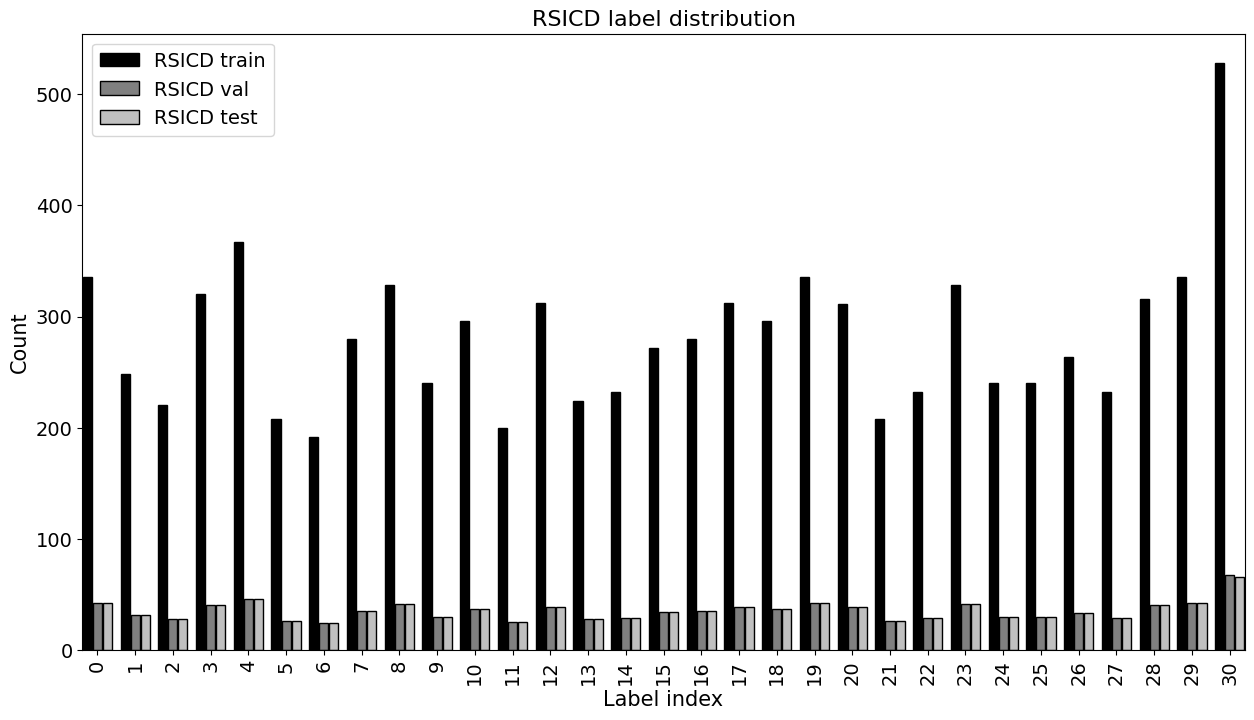

Sum train: 8734
Sum val: 1094
Sum test: 1093


In [10]:
# From: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
def bar_plot_multiple(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, font_size = 12):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis - The axis we want to draw our plot on.

    data: dictionary - A dictionary containing the data to plot. Keys = the names of the data, items = a list of the values.

        Example: data = {"x":[1,2,3], "y":[1,2,3], "z":[1,2,3]}

    colors : array-like, optional, default: None - List of colors to use for the bars. If None, use the standard matplotlib color cyle. 

    total_width : float, optional, default: 0.8 - The width of a bar group. 0.8 means that 80% of the x-axis is covered 
                                                  by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1 - Relative width of one bar within a group. 1 means the bars will touch each other 
        within a group, values less than 1 will make these bars thinner.

    legend: bool, optional, default: True - If true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars, heights_left_bar = [], []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x+x_offset, y, width=bar_width*single_width, color=colors[i % len(colors)], edgecolor = "black")
            height, width, loc = bar[0].get_height(), bar[0].get_width(), bar[0].get_x()
            
            if i % 3 == 0:
                heights_left_bar.append(height)

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if legend = True
    if legend:
        ax.legend(bars, data.keys(), fontsize = font_size, loc = 'upper left')
        
# Resize figure, choose fontsize 
fig, ax = plt.subplots(figsize=(15, 8))
font_size = 14

# Plot the bars and significances
data = {'RSICD train': rsicd_train_counts, 'RSICD val': rsicd_val_counts, 'RSICD test': rsicd_test_counts,}
bar_plot_multiple(ax, data, total_width=.8, single_width=0.9, colors = ['black', 'gray', 'silver', 'white'], font_size = font_size )

# Add text to the plot
plt.title('RSICD label distribution', fontsize = font_size + 2)
plt.xticks(range(rsicd_train_labels.shape[0]), rsicd_train_labels, rotation = 90, fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.ylabel('Count', fontsize = font_size+1)
plt.xlabel('Label index', fontsize = font_size+1)
plt.xlim(min(rsicd_train_labels)-0.4, max(rsicd_train_labels)+0.4)
plt.show()

print('Sum train:', np.sum(rsicd_train_counts))
print('Sum val:', np.sum(rsicd_val_counts))
print('Sum test:', np.sum(rsicd_test_counts))

## UCM

In [11]:
root = './data/UCM'
data = load_captions(os.path.join(root, 'dataset.json'), ['train', 'val'])

In [12]:
path = './data/UCMerced_LandUse/Images'
num_images_in_folders = []
ucm_cls_paths = []
ucm_cls_images = []
folders = []
for folder in os.listdir(path):
    folders.append(folder)
    contents = os.listdir(os.path.join(path, folder))
    num_images_in_folders.append(len(contents))
    for img_name in contents:
        img = Image.open(os.path.join(path, folder, img_name))
        img = np.array(img.resize((256,256)))
        ucm_cls_images.append(img)
        ucm_cls_paths.append(folder)
print(num_images_in_folders)
ucm_cls_images = np.stack(ucm_cls_images)
print(ucm_cls_images.shape)
print(folders)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
(2100, 256, 256, 3)
['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [13]:
path = './data/UCM/dataset.json'
train = load_captions(path, 'train')
val = load_captions(path, 'val')
test = load_captions(path, 'test')
all = load_captions(path, '')

splits = {'train': train, 'val': val, 'test': test}
for s in splits:
    split_contents = splits[s]
    print(s, len(split_contents)/len(all))

train 0.8
val 0.1
test 0.1


In [14]:
ucm_images_path = './data/UCM/images'
ucm_images = []
ucm_paths = []
for img_name in sorted(os.listdir(ucm_images_path), key = lambda x: int(x.split('.')[0])):
    img = Image.open(os.path.join(ucm_images_path, img_name))
    img_np = np.array(img)
    ucm_images.append(img_np)
    ucm_paths.append(img_name)
ucm_images = np.stack(ucm_images)
print(ucm_images.shape)

(2100, 256, 256, 3)


In [15]:
ucm_to_cls_mappings = dict(zip(ucm_paths, ucm_cls_paths))
write_json('./data/UCM/caption_to_cls_mapping.json', ucm_to_cls_mappings)

### Testing whether UCM and UCMerced_LandUse use the same order for the images

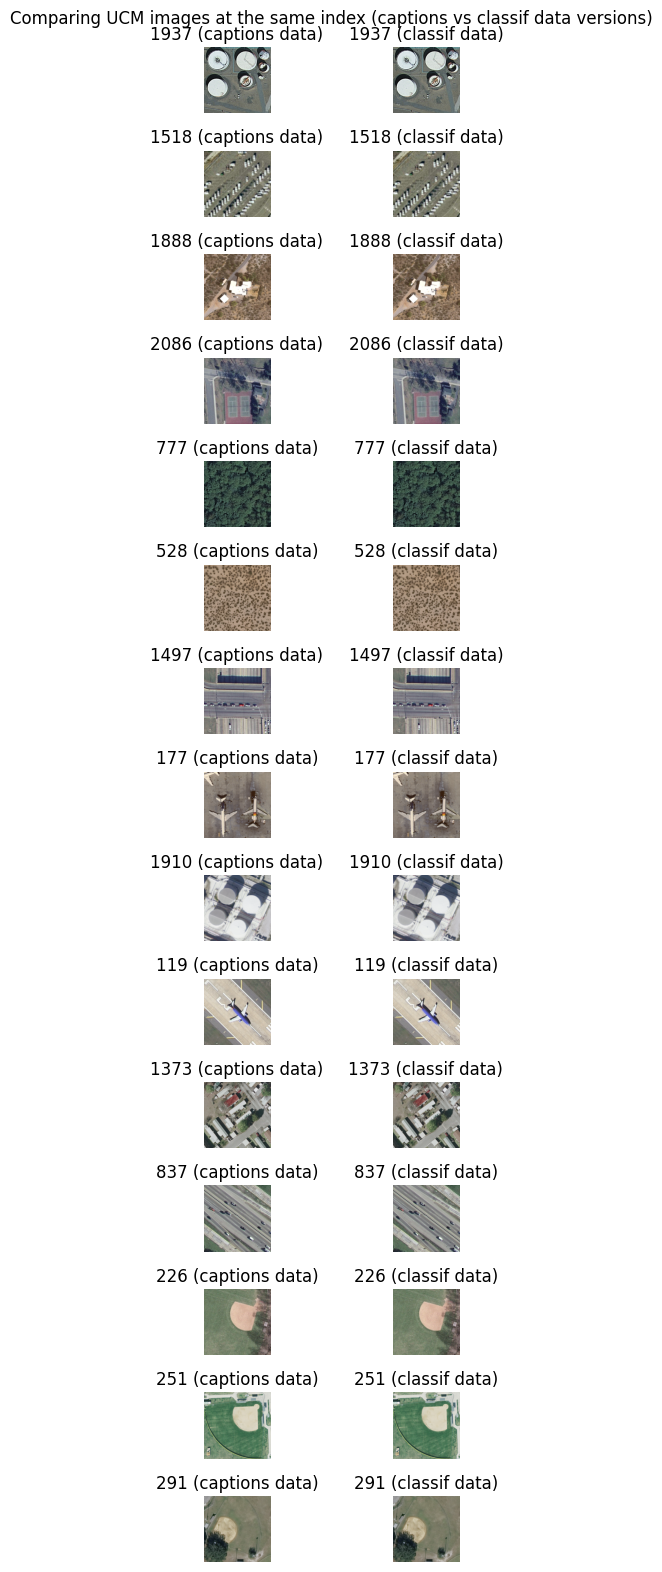

In [16]:
num_comparisons = 15
fig, ax = plt.subplots(num_comparisons, 2, figsize=(5,16))
for i, idx in enumerate(np.random.choice(np.arange(ucm_images.shape[0]), size = num_comparisons, replace = False)):
    ax[i][0].imshow(ucm_images[idx])
    ax[i][1].imshow(ucm_cls_images[idx])
    ax[i][0].set_title('{} (captions data)'.format(idx))
    ax[i][1].set_title('{} (classif data)'.format(idx))
    ax[i][0].axis('off')
    ax[i][1].axis('off')
plt.suptitle('Comparing UCM images at the same index (captions vs classif data versions)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
def ucm_split_counts(ucm_to_cls_mappings, split):
    split_classes = []
    for s in split:
        split_classes.append(ucm_to_cls_mappings[s])
    return Counter(split_classes)
print('Train counts')
ucm_split_counts(ucm_to_cls_mappings, train)

Train counts


Counter({'airplane': 81,
         'harbor': 81,
         'intersection': 81,
         'agricultural': 80,
         'baseballdiamond': 80,
         'beach': 80,
         'buildings': 80,
         'chaparral': 80,
         'forest': 80,
         'freeway': 80,
         'golfcourse': 80,
         'mediumresidential': 80,
         'mobilehomepark': 80,
         'overpass': 80,
         'parkinglot': 80,
         'river': 80,
         'runway': 80,
         'sparseresidential': 80,
         'storagetanks': 80,
         'tenniscourt': 80,
         'denseresidential': 77})

In [18]:
print('Validation counts')
ucm_split_counts(ucm_to_cls_mappings, val)

Validation counts


Counter({'denseresidential': 13,
         'agricultural': 10,
         'baseballdiamond': 10,
         'beach': 10,
         'buildings': 10,
         'chaparral': 10,
         'forest': 10,
         'freeway': 10,
         'golfcourse': 10,
         'mediumresidential': 10,
         'mobilehomepark': 10,
         'overpass': 10,
         'parkinglot': 10,
         'river': 10,
         'runway': 10,
         'sparseresidential': 10,
         'storagetanks': 10,
         'tenniscourt': 10,
         'airplane': 9,
         'harbor': 9,
         'intersection': 9})

In [19]:
print('Test counts')
ucm_split_counts(ucm_to_cls_mappings, test)

Test counts


Counter({'agricultural': 10,
         'airplane': 10,
         'baseballdiamond': 10,
         'beach': 10,
         'buildings': 10,
         'chaparral': 10,
         'denseresidential': 10,
         'forest': 10,
         'freeway': 10,
         'golfcourse': 10,
         'harbor': 10,
         'intersection': 10,
         'mediumresidential': 10,
         'mobilehomepark': 10,
         'overpass': 10,
         'parkinglot': 10,
         'river': 10,
         'runway': 10,
         'sparseresidential': 10,
         'storagetanks': 10,
         'tenniscourt': 10})

In [20]:
path = './data/sydney_captions/dataset.json'
train = load_captions(path, 'train')
val = load_captions(path, 'val')
test = load_captions(path, 'test')
all = load_captions(path, '')
splits = {'train': train, 'val': val, 'test': test}
for s in splits:
    split_contents = splits[s]
    print(f'split {s}\t{round(100*len(split_contents)/len(all),2)}%\t({len(split_contents)}/{len(all)})')
# read_json(path)
# print(os.listdir(path+'/images'))

split train	81.08%	(497/613)
split val	9.46%	(58/613)
split test	9.46%	(58/613)


In [21]:
root = './data/UCM/'

X = list(ucm_to_cls_mappings.keys())
y = list(ucm_to_cls_mappings.values())
N = len(X)
UCM_data = load_captions(os.path.join(root, 'dataset.json'), ['train', 'val'])
X_trainval = []
y_trainval = []
for i, x in enumerate(X):
    if x in UCM_data:
        X_trainval.append(x)
        y_trainval.append(y[i])
store_k_folds(X, y, N, root, print_indices = True)

Fold 0:	Train: ratio=88.86	Val:  ratio=11.14
  Train: index=['1.tif' '2.tif' '3.tif' ... '2098.tif' '2099.tif' '2100.tif']	 Val:  index=['9.tif' '10.tif' '16.tif' '29.tif' '31.tif' '36.tif' '43.tif' '52.tif'
 '55.tif' '57.tif' '85.tif' '88.tif' '126.tif' '142.tif' '149.tif'
 '152.tif' '166.tif' '172.tif' '176.tif' '177.tif' '192.tif' '195.tif'
 '199.tif' '206.tif' '226.tif' '227.tif' '228.tif' '240.tif' '243.tif'
 '249.tif' '275.tif' '280.tif' '296.tif' '298.tif' '302.tif' '309.tif'
 '311.tif' '325.tif' '330.tif' '340.tif' '348.tif' '363.tif' '373.tif'
 '381.tif' '392.tif' '403.tif' '411.tif' '417.tif' '422.tif' '427.tif'
 '439.tif' '476.tif' '478.tif' '495.tif' '497.tif' '500.tif' '503.tif'
 '504.tif' '520.tif' '529.tif' '532.tif' '543.tif' '550.tif' '580.tif'
 '588.tif' '592.tif' '597.tif' '608.tif' '611.tif' '622.tif' '623.tif'
 '635.tif' '638.tif' '656.tif' '668.tif' '675.tif' '676.tif' '695.tif'
 '703.tif' '706.tif' '722.tif' '740.tif' '761.tif' '768.tif' '777.tif'
 '780.tif' '783

In [22]:
# I want to probably get the dict['items'] values for each folder and then take the images from there.
working_datasets = [] #['RSICD', 'UCM', 'Sydney', 'Fashion200k', 'SciCap', 'RSICD-CLS', 'UCM-CLS', 'Fashion200k-CLS', 'WHU-RS19', 'RSSCN7', 
                    #'AID', 'RESISC45', 'Simpsons-Images', 'Polyvore', 'Polyvore-CLS', 'FashionGen', 'FashionGen-CLS']
# get_custom_data(args, data, preprocess_fn, is_train, cls, subclass, **data_kwargs):
for dataset in working_datasets:
    print(dataset)
    cls = 'CLS' in dataset
    # CLS version of most datasets just uses the non-CLS dataloader, but adds cls = True as argument
    if dataset != 'UCM-CLS': # Exception: UCM-CLS is a different dataloader altogether than UCM!
        dataset = dataset.replace('-CLS', '')
    get_custom_data(None, data = dataset, preprocess_fn = None, is_train = True,)

# Fashion data

## Fashion200k

In [23]:
path = './data/fashion200k/labels'
print(os.listdir(path))
train_entries = []
test_entries = []
for file in os.listdir(path):
    if os.path.isdir(os.path.join(path, file)):
        continue
    with open(os.path.join(path, file), 'r') as f:
        contents = f.read().split('\n')
        img_paths = [c.split('\t')[0] for c in contents if len(c) > 0]
    if 'train' in file:
        train_entries.extend(img_paths)
    else:
        test_entries.extend(img_paths)

['dress_test_detect_all.txt', 'dress_train_detect_all.txt', 'jacket_test_detect_all.txt', 'jacket_train_detect_all.txt', 'pants_test_detect_all.txt', 'pants_train_detect_all.txt', 'skirt_test_detect_all.txt', 'skirt_train_detect_all.txt', 'top_test_detect_all.txt', 'top_train_detect_all.txt', 'folds']


In [24]:
train_N = len(train_entries)
test_N = len(test_entries)
N = train_N + test_N
train_N, test_N, round(100*test_N/N,4)

(172049, 29789, 14.7589)

In [25]:
y_train, y_test = [], []
X_train = train_entries
for entry in train_entries:
    elements = entry.split('/')
    y_train.append(elements[1])
for entry in test_entries:
    elements = entry.split('/')
    y_test.append(elements[1])

train_val_y_counts = Counter(y_train)
test_y_counts = Counter(y_test)
for class_ in train_val_y_counts:
    count_train_val = train_val_y_counts[class_]
    count_test = test_y_counts[class_]
    total = count_train_val + count_test
    print(class_, 'train', round(count_train_val/total, 2), 'test', round(count_test/total, 2))
print('Class frequencies (train):', train_val_y_counts)
print('Class frequencies (test):',test_y_counts)

dresses train 0.9 test 0.1
jackets train 0.84 test 0.16
pants train 0.83 test 0.17
skirts train 0.84 test 0.16
tops train 0.83 test 0.17
Class frequencies (train): Counter({'dresses': 52990, 'tops': 40670, 'skirts': 29423, 'pants': 26301, 'jackets': 22665})
Class frequencies (test): Counter({'tops': 8164, 'dresses': 6114, 'skirts': 5706, 'pants': 5343, 'jackets': 4462})


In [26]:
store_k_folds(X_train, y_train, N, path, folds_folder = 'folds', n_splits = 9, print_indices = False)

Fold 0:	Train: ratio=75.77	Val:  ratio=9.47
Fold 1:	Train: ratio=75.77	Val:  ratio=9.47
Fold 2:	Train: ratio=75.77	Val:  ratio=9.47
Fold 3:	Train: ratio=75.77	Val:  ratio=9.47
Fold 4:	Train: ratio=75.77	Val:  ratio=9.47
Fold 5:	Train: ratio=75.77	Val:  ratio=9.47
Fold 6:	Train: ratio=75.77	Val:  ratio=9.47
Fold 7:	Train: ratio=75.77	Val:  ratio=9.47
Fold 8:	Train: ratio=75.77	Val:  ratio=9.47


## FashionGen

In [27]:
import h5py
def h5_to_np(h5_lst):
    # Convert to numpy array
    np_lst = np.array(h5_lst[:].tolist())
    # Decode byte-type (string) data and make lowercase
    mapping = lambda x: x.decode('UTF-8').lower()
    np_mapper = np.vectorize(mapping)
    if h5_lst.dtype == int:
        return np_lst.flatten()
    return np_mapper(np_lst).flatten()

path = './data/fashiongen'
print(os.listdir(path))
h5_path = os.path.join(path, f"fashiongen_256_256_train.h5") # hdf5
train_data = h5py.File(h5_path)

h5_path = os.path.join(path, f"fashiongen_256_256_validation.h5") # hdf5
test_data = h5py.File(h5_path)

train_classes = h5_to_np(train_data['input_category'])
train_idx = h5_to_np(train_data['index'])

test_classes = h5_to_np(test_data['input_category'])
test_idx = h5_to_np(test_data['index'])

# Print the total number of classes
print(len(set(train_classes).union(set(test_classes))))

['fashiongen_256_256_train.h5', 'fashiongen_256_256_validation.h5', 'folds']
48


In [28]:
x_train = train_idx
y_train = train_classes
N = train_idx.shape[0] + test_idx.shape[0]
store_k_folds(x_train, y_train, N, path, folds_folder = 'folds', n_splits = 9, print_indices = False)

Fold 0:	Train: ratio=79.02	Val:  ratio=9.88
Fold 1:	Train: ratio=79.02	Val:  ratio=9.88
Fold 2:	Train: ratio=79.02	Val:  ratio=9.88
Fold 3:	Train: ratio=79.02	Val:  ratio=9.88
Fold 4:	Train: ratio=79.02	Val:  ratio=9.88
Fold 5:	Train: ratio=79.02	Val:  ratio=9.88
Fold 6:	Train: ratio=79.02	Val:  ratio=9.88
Fold 7:	Train: ratio=79.02	Val:  ratio=9.88
Fold 8:	Train: ratio=79.02	Val:  ratio=9.88


In [29]:
train_val_y_counts = Counter(train_classes)
test_y_counts = Counter(test_classes)
for class_ in train_val_y_counts:
    count_train_val = train_val_y_counts[class_]
    count_test = test_y_counts[class_]
    total = count_train_val + count_test
    print(class_, 'train', round(count_train_val/total, 2), 'test', round(count_test/total, 2))

shirts train 0.89 test 0.11
sweaters train 0.89 test 0.11
jeans train 0.89 test 0.11
pants train 0.89 test 0.11
tops train 0.89 test 0.11
suits & blazers train 0.89 test 0.11
shorts train 0.89 test 0.11
jackets & coats train 0.89 test 0.11
ties train 0.89 test 0.11
hats train 0.89 test 0.11
skirts train 0.89 test 0.11
jumpsuits train 0.89 test 0.11
swimwear train 0.89 test 0.11
dresses train 0.89 test 0.11
belts & suspenders train 0.88 test 0.12
lingerie train 0.89 test 0.11
scarves train 0.88 test 0.12
gloves train 0.89 test 0.11
fine jewelry train 0.89 test 0.11
clutches & pouches train 0.88 test 0.12
blankets train 0.89 test 0.11
jewelry train 0.89 test 0.11
backpacks train 0.89 test 0.11
shoulder bags train 0.89 test 0.11
underwear & loungewear train 0.82 test 0.18
keychains train 0.89 test 0.11
tote bags train 0.89 test 0.11
boat shoes & moccasins train 1.0 test 0.0
pouches & document holders train 0.89 test 0.11
sneakers train 0.89 test 0.11
duffle & top handle bags train 0.89 te

In [30]:
train_val_y_counts

Counter({'tops': 47764,
         'sweaters': 44591,
         'jackets & coats': 35035,
         'pants': 23230,
         'jeans': 13586,
         'shirts': 11398,
         'sneakers': 10478,
         'dresses': 9458,
         'shorts': 7416,
         'shoulder bags': 6952,
         'skirts': 6909,
         'jewelry': 4933,
         'hats': 4545,
         'boots': 4515,
         'flats': 3855,
         'sandals': 3515,
         'backpacks': 2858,
         'suits & blazers': 2845,
         'eyewear': 2494,
         'tote bags': 2281,
         'heels': 1931,
         'duffle & top handle bags': 1533,
         'lingerie': 1314,
         'scarves': 1138,
         'clutches & pouches': 1120,
         'lace ups': 631,
         'jumpsuits': 610,
         'messenger bags & satchels': 530,
         'loafers': 481,
         'fine jewelry': 475,
         'belts & suspenders': 335,
         'ties': 253,
         'socks': 250,
         'keychains': 202,
         'swimwear': 201,
         'pouches & 

## Polyvore

In [31]:
path = './data/polyvore_outfits/'
os.listdir(path)
print(os.listdir(path + 'disjoint'))

['valid.json', 'train.json', 'compatibility_test.txt', 'train_hglmm_pca6000.txt', 'fill_in_blank_valid.json', 'test.json', 'compatibility_train.txt', 'fill_in_blank_test.json', 'compatibility_valid.txt', 'typespaces.p', 'fill_in_blank_train.json']


In [32]:
train_set = read_json(os.path.join(path, "disjoint/train.json"))
val_set = read_json(os.path.join(path, "disjoint/valid.json"))
test_set = read_json(os.path.join(path, "disjoint/test.json"))

polyvore_json = read_json(os.path.join(path, 'polyvore_item_metadata.json'))
x = set(polyvore_json.keys())

In [33]:
def get_ids(split):
    # Make a list of all the image IDs belonging to the current split
    split_item_ids = []
    for grouping in split:
        items = grouping['items']
        item_ids = [item['item_id'] for item in items] # Get image IDs
        split_item_ids += item_ids
    split_item_ids = set(split_item_ids)
    return split_item_ids

train_x = get_ids(train_set)
val_x = get_ids(val_set)
test_x = get_ids(test_set)

train_val_x = train_x.union(val_x)
all_x = train_x.union(val_x.union(test_x))

In [34]:
train_val_y = []
for item_key in train_val_x:
    item = polyvore_json[item_key]['semantic_category']
    train_val_y.append(item)

test_y = []
for item_key in test_x:
    item = polyvore_json[item_key]['semantic_category']
    test_y.append(item)

In [35]:
# Check whether Polyvore is split in a stratified manner
train_val_y_counts = Counter(train_val_y)
test_y_counts = Counter(test_y)
for class_ in train_val_y_counts:
    count_train_val = train_val_y_counts[class_]
    count_test = test_y_counts[class_]
    total = count_train_val + count_test
    print(class_, 'train', round(count_train_val/total, 2), 'test', round(count_test/total, 2))

bottoms train 0.54 test 0.46
jewellery train 0.56 test 0.44
sunglasses train 0.6 test 0.4
shoes train 0.54 test 0.46
tops train 0.54 test 0.46
outerwear train 0.48 test 0.52
scarves train 0.49 test 0.51
bags train 0.54 test 0.46
all-body train 0.56 test 0.44
hats train 0.56 test 0.44
accessories train 0.51 test 0.49


In [36]:
train_val_y_counts

Counter({'shoes': 15331,
         'jewellery': 13838,
         'bags': 13609,
         'tops': 10570,
         'bottoms': 9070,
         'all-body': 6616,
         'outerwear': 4849,
         'sunglasses': 3714,
         'accessories': 1976,
         'hats': 1935,
         'scarves': 1335})

In [37]:
test_y_counts

Counter({'shoes': 13225,
         'bags': 11688,
         'jewellery': 10680,
         'tops': 9005,
         'bottoms': 7695,
         'outerwear': 5265,
         'all-body': 5170,
         'sunglasses': 2449,
         'accessories': 1931,
         'hats': 1529,
         'scarves': 1398})

In [38]:
store_k_folds(list(train_val_x), train_val_y, len(all_x), path, folds_folder = 'folds', n_splits = 9, print_indices = False)

Fold 0:	Train: ratio=48.2	Val:  ratio=6.02
Fold 1:	Train: ratio=48.2	Val:  ratio=6.02
Fold 2:	Train: ratio=48.2	Val:  ratio=6.02
Fold 3:	Train: ratio=48.2	Val:  ratio=6.02
Fold 4:	Train: ratio=48.2	Val:  ratio=6.02
Fold 5:	Train: ratio=48.2	Val:  ratio=6.02
Fold 6:	Train: ratio=48.2	Val:  ratio=6.02
Fold 7:	Train: ratio=48.2	Val:  ratio=6.02
Fold 8:	Train: ratio=48.2	Val:  ratio=6.02
